In [1]:
# !export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda/
!export CUDA_DIR=/usr/lib/cuda/
# !export LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64:/home/pedro/miniconda3/envs/ml2/lib/
# !export TF_GPU_ALLOCATOR=cuda_malloc_async

In [2]:
!ls ${CUDA_DIR}/nvvm/libdevice

libdevice.10.bc


In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
import tensorflow as tf
import tensorflow.keras as keras


gpus = tf.config.list_physical_devices("GPU")
print(f"gpus={gpus}")

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
import tensorflow_addons as tfa
import datetime
import random
import time

2022-11-26 15:09:21.721306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 15:09:21.816192: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-26 15:09:22.191151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2022-11-26 15:09:22.191189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or

gpus=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2022-11-26 15:09:22.640921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 15:09:22.641176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 15:09:22.659011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 15:09:22.659253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 15:09:22.659486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [5]:
!wget https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

In [6]:
import tensorflow_datasets as tfds
from functools import reduce
splits = tfds.even_splits('train', n=200, drop_remainder=True)

# Load 1/3 of the train split.
# ds = tfds.load('my_dataset', split=split0)

train_ds_base =  tfds.load("coil100", split=reduce(lambda x,y: x+y, splits[1:]))
test_ds_base = tfds.load("coil100", split=splits[0])

2022-11-26 15:09:23.200999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 15:09:23.289886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 15:09:23.290083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 15:09:23.290255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:
print(len(train_ds_base))
print(len(test_ds_base))

7164
36


In [8]:
IMG_H = 128
IMG_W = 128
IMG_CHANNELS = 3

In [9]:
train_ds = train_ds_base.map(lambda data: data["image"])
test_ds = test_ds_base.map(lambda data: data["image"])
print(len(train_ds), len(test_ds))

7164 36


In [10]:
random.randint(1,4)

2

In [11]:
def infinite_sequence():
    num = 0
    while True:
        yield num
        num += 1

<MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None))>


2022-11-26 15:09:25.063519: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


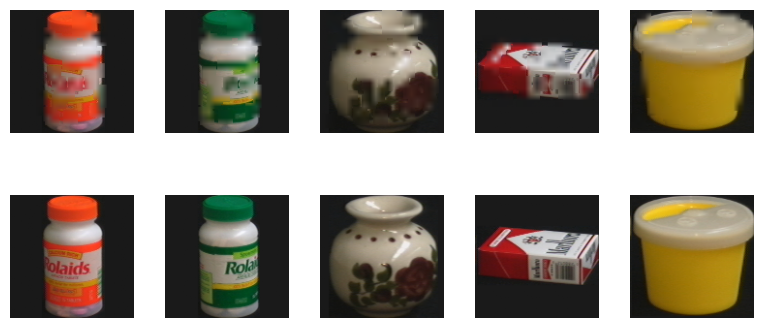

2022-11-26 15:09:25.753474: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


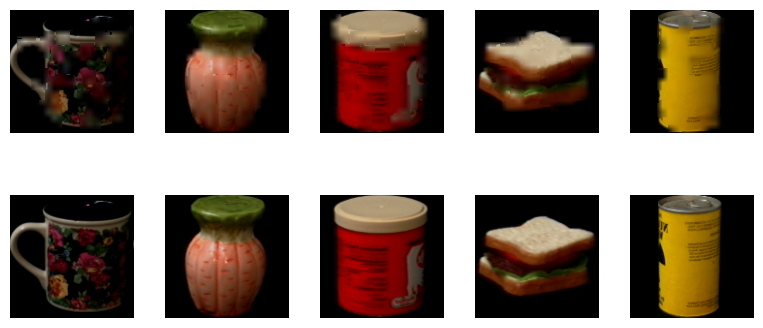

In [12]:
from utils import NoiseUtil, ImgUtils, DataLoader, DataManager
           
def add_noise(x,y):
#     downsize_image_ratio = random.choice([1/2,1/3,1/6])
#     resized_size_h = x.shape[1]
#     resized_size_w = x.shape[2]
#     down = tf.image.resize(
#         x,
#         [int(resized_size_h * downsize_image_ratio), int(resized_size_w * downsize_image_ratio)],
#         preserve_aspect_ratio=True,
#         antialias=False,
#         name=None)
    
    

#     return tf.image.resize(
#         down,
#         [resized_size_h, resized_size_w],
#         preserve_aspect_ratio=True,
#         antialias=False,
#         name=None), y
    
    
#     print(x.shape)

    
    n = NoiseUtil.pixel_noise(x, random.choice([50]), 15, downsize_image_ratios=[1/4, 1/6])

#     n = n + 0.2 * tf.random.normal(
#         n.shape[1:],
#         mean=0.0,
#         stddev=1.0,
#         dtype=tf.dtypes.float32,
#     )

    return n,y

def augment(x):
    seed = (2, 3)
    x = tf.image.stateless_random_flip_left_right(x, seed)
    
    tt = random.randint(1,3)
    
    if tt == 1:
        x = tf.image.stateless_random_contrast(x, 0.5, 1., seed)
    if tt == 2:
        x = tf.image.stateless_random_brightness(x, 0.2, seed)
    if tt == 3:
        x = tf.image.stateless_random_saturation(x, 0.3, 1.0, seed)
    return x

dm = DataManager.create_label_from_dataset_with_input_transform(train_ds, test_ds, (128,128,3), add_noise, base_transform=augment)
print(dm.train_ds)
# dm.print_validation(lambda x: model.generator(x, training=False)) 
dm.print_validation()

In [13]:
imgg1 ,imgg2 = next(iter(dm.get_test_data(5)))

# imgg = ImgUtils.normalize(imgg)

# plt.imshow(imgg1[0])

same = 1 - tf.image.ssim_multiscale(imgg1, imgg1, 1.0, filter_size=6)
print(same)
individuals = 1 - tf.image.ssim_multiscale(imgg1, imgg2, 1.0, filter_size=6)
ms_loss = tf.math.reduce_sum(individuals)
print(individuals)

print(ms_loss)


print("SSIM Multiscale")

print(f"Same:{tf.math.reduce_mean(tf.image.ssim_multiscale(imgg2, imgg2, 1.0, filter_size=3))}")
print(f"With resized: {tf.math.reduce_mean(tf.image.ssim_multiscale(imgg1, imgg2, 1.0, filter_size=3))}")

print("Accuracy:")
print(f"Same:{tf.math.reduce_mean(tf.keras.metrics.categorical_accuracy(imgg2, imgg2))}")
print(f"With resized:{tf.math.reduce_mean(tf.keras.metrics.categorical_accuracy(imgg2, imgg1))}")

2022-11-26 15:09:26.566402: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0.0478465  0.03620368 0.05576402 0.05466312 0.02961582], shape=(5,), dtype=float32)
tf.Tensor(0.22409314, shape=(), dtype=float32)
SSIM Multiscale
Same:1.0
With resized: 0.9473868608474731
Accuracy:
Same:1.0
With resized:0.925537109375


2022-11-26 15:09:27.008113: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


In [14]:
# im = tf.reshape(tf.constant(range(2*12*12*1)), (2,12,12,1))

# NoiseUtil.pixel_noise(im, 10, 2)[:,:,:,0]

In [15]:
LATENT_SIZE = 32

In [16]:
n1 = infinite_sequence()
def get_conv_t(filters, norm=False, active=True):
    conv = tf.keras.Sequential(name=f"conv_t_c{filters}_{next(n1)}")
    if norm:
        conv.add(tfa.layers.SpectralNormalization(
            layers.Conv2DTranspose(filters, 2, 2, padding="same")
        ))
    else:
        conv.add(layers.Conv2DTranspose(filters, 2, 2, padding="same"))
    if active:
        conv.add(layers.LeakyReLU())
    return conv

class NoiseLayer(layers.Layer):

    def __init__(self):
        super(NoiseLayer, self).__init__()
        
    def call(self, inputs, training=False):
        if training:
            return inputs + 0.2 * tf.random.normal(
                inputs.shape[1:],
                mean=0.0,
                stddev=1.0,
                dtype=tf.dtypes.float32,
            )
        return inputs


class InceptionBlock(layers.Layer):

    def __init__(self, filters=32, strides=1):
        super(InceptionBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        
    def get_config(self):
        return super().get_config().copy()
    
    def build(self, input_shape):  # Create the state of the layer (weights)
        filters = self.filters
        self.conv_x1 = get_conv(filters, kernel=2, strides=self.strides)
        self.conv_x2 = get_conv(filters, kernel=3, strides=self.strides)
        self.conv_x3 = get_conv(filters, kernel=5, strides=self.strides)
        self.out = get_conv(filters, kernel=1, strides=1)

    def call(self, inputs):  # Defines the computation from inputs to outputs
        x1 = self.conv_x1(inputs)
        x2 = self.conv_x2(inputs)
        x3 = self.conv_x3(inputs)

        x = tf.concat([x1,x2,x3], axis=-1)
#         x = self.dropout(x)
        x = self.out(x)
        return x

n2 = infinite_sequence()
def get_conv(filters, kernel=2, strides=2, norm=False, active=True):
    conv = tf.keras.Sequential(name=f"conv_c{filters}k{kernel}s{strides}_{next(n2)}")
    if norm:
        conv.add(tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel, strides, padding="same")
        ))
    else:
        conv.add(layers.Conv2D(filters, kernel, strides, padding="same"))
    if active:
        conv.add(layers.LeakyReLU())
    return conv
    

class AutoEncoderOpts:
    def __init__(self, feed_forward_dropout_rate):
        self.feed_forward_dropout_rate = feed_forward_dropout_rate
        

def get_autoencoder(encoder_convs, dropout_rate, inception_block_size, input_size, feed_forward_dropout_rate):
    img_inputs = keras.Input(shape=input_size)

#     x = InceptionBlock(inception_block_size)(img_inputs)
#     x = get_conv(6, 3, 1)(img_inputs)
#     if dropout_rate > 0:
#         x = layers.Dropout(dropout_rate)(x)
#     x = layers.LeakyReLU()(x)
#     x = NoiseLayer()(img_inputs)

    dr = tf.Variable(feed_forward_dropout_rate)
    
    opts = AutoEncoderOpts(dr)
    x = img_inputs
    feed_forward = []
#     feed_forward.append(x)
    
    for i, (f, s) in enumerate(encoder_convs):
        x = get_conv(f, 3, s, norm=True)(x)
#         if i == 0 and dropout_rate > 0:
#             x = layers.SpatialDropout2D(dropout_rate)(x)
#         feed_forward.append(x)
    
   # encoder = keras.Model(img_inputs, x, name="encoder")
    encoder_out = x
    sh = x.shape
    new_shape = [*sh[1:]]
        
    x = layers.Flatten()(x)
#     b,w = x.shape
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU()(x)
#     x = layers.Dense(w)(x)
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape(new_shape)(x)
    
    feed_forward.reverse()
    encoder_convs.reverse()
        
    for count, (f, s) in enumerate(encoder_convs):
#         if count < len(feed_forward):
#             y = feed_forward[count]
#             y = layers.SpatialDropout2D(dr)(y)
#             if dr > 0:
#             x = tf.concat([y, x], axis=-1)
#             x = get_conv(f, 1, 1, norm=True)(x)
        x = get_conv_t(f, norm=True, active=False)(x) if s > 1 else get_conv(f, 3, s, active=False)(x)
        x = layers.LeakyReLU()(x)
        
#     del feed_forward
    x = layers.Conv2D(IMG_CHANNELS, 3, padding='same', activation='sigmoid', name="conv2d_output")(x)
    
    #decoder = keras.Model(encoder_out, x, name="encoder")
    
    return keras.Model(img_inputs, x, name="autoencoder"), opts

In [17]:
dr = tf.Variable(0.1)
print(dr)
dr.assign(0.2)
print(dr)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.2>


In [18]:
def disc_bloc(filters, strides, name):
    model = tf.keras.Sequential(name=name)
    model.add(tfa.layers.SpectralNormalization(
        layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')))
#     model.add(layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same'))
    model.add(layers.LeakyReLU())
    return model


def get_discriminator():
    filters = 128
    model = tf.keras.Sequential(name="discriminator")
    model.add(
        layers.Conv2D(filters, kernel_size=3, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(disc_bloc(512, 2, name="disc_bloc_1"))
#     model.add(disc_bloc(filters*2, 1))
    model.add(disc_bloc(256, 2, name="disc_bloc_2"))
#     model.add(disc_bloc(filters*4, 1))
    model.add(disc_bloc(512, 2, name="disc_bloc_3"))
#     model.add(disc_bloc(512, 1))
    model.add(disc_bloc(512, 2, name="disc_bloc_4"))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [20]:
BATCH_SIZE = 8
EPOCHS=1000
steps_per_epoch=500

In [21]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__(name="GAN")
        self.generator = generator
        self.discriminator = discriminator
        
#         boundaries = [steps_per_epoch*10, steps_per_epoch*25, steps_per_epoch*60, steps_per_epoch*90, steps_per_epoch*95]
#         values = [0.0005, 0.0004, 0.0003, 0.0002, 0.0001, 0.00005]
#         values2 = [0.001, 0.0005, 0.0005, 0.0002, 0.0001, 0.00005]
#         gen_lr = keras.optimizers.schedules.PiecewiseConstantDecay(
#             boundaries, values)
# #         gen_lr = 0.00001
#         disc_lr = keras.optimizers.schedules.PiecewiseConstantDecay(
#             boundaries, values2)
#         self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_lr, beta_1=0.5)
#         self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=disc_lr, beta_1=0.5)
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00004, beta_1=0.5)
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")

#         self.gen_loss = tf.keras.metrics.Mean(name='gen_loss')
#         self.disc_loss = tf.keras.metrics.Mean(name='disc_loss')
#         self.gen_eval_loss = tf.keras.metrics.Mean(name='gen_eval_loss')
        
#         self.disc_train_loss = tf.keras.metrics.Mean(name='disc_train_loss')
#         self.disc_eval_loss = tf.keras.metrics.Mean(name='disc_eval_loss')
        
    def call(self, all_images, training=False):
        resized, images = all_images
        generated_images = self.generator(resized, training=training)
#         fake_output = self.discriminator(generated_images, training=False)
#         gen_loss = generator_loss(fake_output)
#         self.add_loss(gen_loss)
        return generated_images, images


    def test_step(self, all_images):
        # Unpack the data
        resized, images = all_images
        discriminator = self.discriminator
        generator = self.generator
        
        generated_images = generator(resized, training=False)

        real_output = discriminator(images, training=False)
        fake_output = discriminator(generated_images, training=False)

        # Updates the metrics tracking the loss
#         self.compiled_loss(real_output, fake_output, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(images, generated_images)
        
        
        gen_loss = generator_loss(real_output, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
            
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics} 
    
        
    def train_step(self, all_images):
        resized, images = all_images
        discriminator = self.discriminator
        generator = self.generator
        generator_optimizer = self.generator_optimizer
        discriminator_optimizer = self.discriminator_optimizer
        
        with tf.GradientTape() as gen_tape:
            
            generated_images = generator(resized, training=True)

            real_output = discriminator(images, training=False)
            fake_output = discriminator(generated_images, training=False)
            gen_loss = generator_loss(real_output, fake_output)
            
            mse_loss = mse(images, generated_images)
            
            gen_loss = tf.cond(gen_loss > 5.0, lambda:mse_loss, lambda:gen_loss)
            
            
        with tf.GradientTape() as disc_tape:
            
            generated_images = generator(resized, training=False)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            disc_loss = discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
#       
#         self.compiled_loss(real_output, fake_output, regularization_losses=self.losses)
        self.compiled_metrics.update_state(images, generated_images)
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

In [22]:
from utils import SSIM, SSIM_Multiscale

In [23]:
import os

ecs = [
#     [(16,1),(16,2),(32,2),(32,2), (64,2), (64,2), (128,2)], 
#     [(16,1),(32,2),(64,2),(128,2), (256,2), (512,2), (1024,2)]
    
#     ([(8,1),(8,2),(16,2),(32,2), (64,2), (128,2), (256,2)], 'f1'), 
#     ([(16,1),(16,2),(32,2),(64,2), (128,2), (256,2), (512,2)], 'f2'), 
    ([(512,2),(512,2),(512,2),(512,2), (512,2), (512,2)], 'f3'), 
    ]

VERSION = "v13"

# filters_count = map(lambda x: x+1, range(len(ecs)))

# for encoder_convs, i in zip(ecs, filters_count):
#     for inception_block_size in [6]:
#         for dropout_rate in [0.4, 0.5]:
#             print(f"{VERSION}_dropout_rate={dropout_rate}_case{i}", encoder_convs)

v13/gan_no_ff_3/dropout=0.2_lr<keras.optimizers.schedules.learning_rate_schedule.PiecewiseConstantDecay object at 0x7f8d707c2760>_casef3


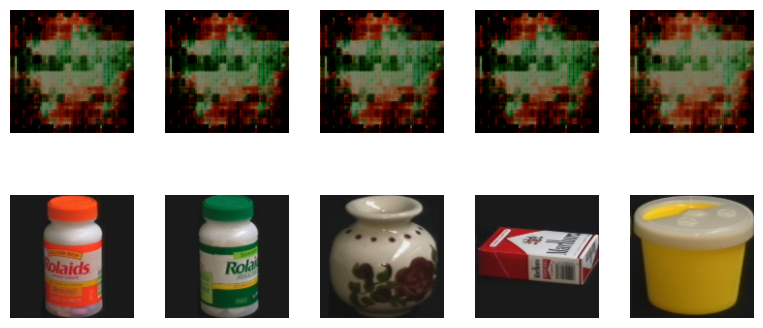

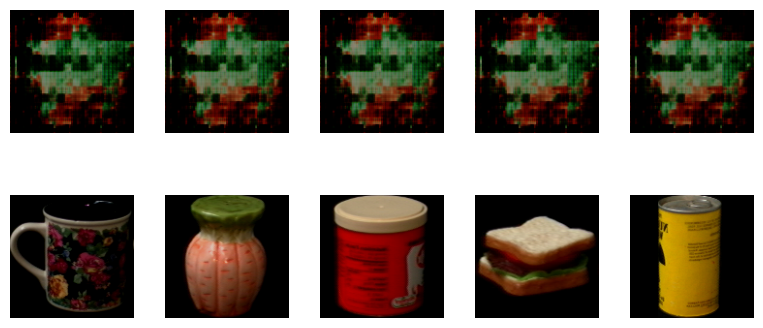

500/500 [==============================] - 103s 207ms/step - mse: 0.0570 - accuracy: 0.5567 - ssim: 0.3863 - ssim_ms: 0.2244 - gen_loss: 0.0570 - disc_loss: 9.6808e-04 - val_mse: 0.0583 - val_accuracy: 0.6094 - val_ssim: 0.2897 - val_ssim_ms: 0.2866 - val_gen_loss: 5.5627 - val_disc_loss: 0.2649
Epoch 197/1000
500/500 [==============================] - 102s 204ms/step - mse: 0.0431 - accuracy: 0.6192 - ssim: 0.3984 - ssim_ms: 0.3457 - gen_loss: 0.0431 - disc_loss: 9.3169e-04 - val_mse: 0.0493 - val_accuracy: 0.7705 - val_ssim: 0.4402 - val_ssim_ms: 0.2613 - val_gen_loss: 7.7925 - val_disc_loss: 1.5740
Epoch 198/1000
500/500 [==============================] - 102s 204ms/step - mse: 0.0375 - accuracy: 0.6611 - ssim: 0.4375 - ssim_ms: 0.3852 - gen_loss: 0.0375 - disc_loss: 9.0397e-04 - val_mse: 0.0489 - val_accuracy: 0.7850 - val_ssim: 0.4774 - val_ssim_ms: 0.3067 - val_gen_loss: 9.0857 - val_disc_loss: 1.8349
Epoch 199/1000
500/500 [==============================] - 102s 205ms/step - mse

KeyboardInterrupt: 

In [24]:
print("Provide a name for the experiment")
# in_run_name = input()
in_run_name = 'gan_no_ff_3'

run_name = in_run_name if len(in_run_name) > 0 else run_name
if len(run_name) == 0:
    raise Exception("Provide a name for the experiment")
    
cases = map(lambda x: x+1, range(len(ecs)))

learning_rate_fn = 1e-5

boundaries = [steps_per_epoch*200]
values = [1e-5, 1e-6]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

for encoder_convs, i in ecs:
    for inception_block_size in [6]:
        for dropout_rate in [0.2]:
            for feed_forward_dropout_rate in [0.3]:
                
                total_dropout = dropout_rate + feed_forward_dropout_rate + 7
                speed_lr = 1

                current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                train_name = f"{VERSION}/{run_name}/dropout={dropout_rate}_lr{learning_rate_fn}_case{i}"
                train_log_dir = f'logs/coil_100_gan/{train_name}/'
                tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = train_log_dir,
                  write_graph=True,
                  histogram_freq = 1,
                  update_freq="batch"
                  )

                generator, opts = get_autoencoder(encoder_convs, dropout_rate, inception_block_size, (128,128,3),feed_forward_dropout_rate)
    #             generator = AutoEncoder(encoder_convs, decoder_convs, dropout_rate=dropout_rate, inception_block_size=inception_block_size)
                discriminator = get_discriminator()
                model = GAN(generator, discriminator)
            
            
                checkpoint_dir = './coil100_gan_checkpoints_noff'
                checkpoint_prefix = os.path.join(checkpoint_dir)
                checkpoint = tf.train.Checkpoint(model=model)
                ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
                
#                 try:
#                     if ckpt_manager.latest_checkpoint:
#                         checkpoint.restore(ckpt_manager.latest_checkpoint)
#                 except:
#                     print("Could not restore the checkopint")
            

                # model = GAN(generator, discriminator)
                def expand_and_predict(x):
                    gen = generator(x, training=False)
                #     t = discriminator(x)
                #     f = discriminator(gen)
                #     print(f"t={tf.squeeze(t)}")
                #     print(f"f={tf.squeeze(f)}")

                    return gen

                class SkMetrics(keras.callbacks.Callback):
                    def on_train_begin(self, logs={}):
                        self.validation_loss = []
                        self.epoch_n = 0
                        self.start = time.time()
                        self.epochs = 0
                        tf.summary.scalar("start_time", self.start )

                    def on_train_end(self, logs={}):
                        self.end = time.time()
                        f = open("training_log.txt", "a")
                        f.write(f"{train_name} finished after epoch {self.epochs} at {time.time()}\n")
                        f.close()


                        tf.summary.scalar("end_time", self.end )
                        tf.summary.scalar("training_time", self.end-self.start)

                    def on_epoch_begin(self, epoch, logs):
                        self.epoch_start = time.time()
                        tf.summary.scalar("epoch_start_time", self.epoch_start, step=epoch)

                    def on_epoch_end(self, epoch, logs):
                        self.epoch_n = epoch
                        self.epoch_end = time.time()
                        self.epochs = epoch
                        tf.summary.scalar("epoch_end_time", self.epoch_end, step=epoch)
                        tf.summary.scalar("epoch_total_time", self.epoch_end-self.epoch_start, step=epoch)
                        ckpt_save_path = ckpt_manager.save()

                        if epoch % 15 == 0:
                            images_path = f"./col_100_output_images/{train_name}/"
                            image_name = images_path + f"e_{epoch}.jpg"

                            if not os.path.exists(images_path):

                                os.makedirs(images_path, exist_ok=True)

                            display.clear_output()
                            print(train_name)
                            dm.print_validation(expand_and_predict, save=True, path=image_name)





                

                cross_entropy = tf.keras.losses.BinaryCrossentropy()

                # opt = tf.keras.optimizers.Adam(learning_rate=0.001)

                # model.compile(run_eagerly=True)
                #
                class DropoutRate(keras.callbacks.Callback):
                    def __init__(self, opts, alpha=0.1, top=0.7):
                        self.opts = opts   
                        self.alpha = alpha
                        self.top = top
                    def on_epoch_end(self, epoch, logs={}):
                        k = self.opts.feed_forward_dropout_rate
                        if k + self.alpha < self.top:
                            k.assign(k + self.alpha)
                        tf.summary.scalar("dropout_rate", k, step=epoch)

                
                def custom_loss(y_true, y_pred):
                    ep = 0.00000000001

    #                 individuals = 1 - tf.image.ssim_multiscale(imgg1, imgg2, 1.0, filter_size=6)
    #                 ms_loss = tf.math.reduce_sum(individuals)

                    individuals = 1 - tf.image.ssim_multiscale(y_true, y_pred, 255.0, filter_size=3)
                    return tf.math.reduce_mean(individuals) 

                early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=10, min_delta=0.)

#                 opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
#                 generator.compile(loss=custom_loss, optimizer=opt, metrics=["mse", "accuracy", SSIM(), SSIM_Multiscale()])
#                 generator.fit(dm.get_training_data(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat(),
#                               epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
#                               validation_data=dm.get_test_data(BATCH_SIZE), 
#                               callbacks=[SkMetrics(), tboard_callback])
                model.compile(loss="mse", metrics=["mse", "accuracy", SSIM(), SSIM_Multiscale()])
                history = model.fit(dm.get_training_data(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat(),
                                    epochs=EPOCHS, 
                                    steps_per_epoch=steps_per_epoch, 
                                    validation_data=dm.get_test_data(BATCH_SIZE), callbacks=[SkMetrics(), tboard_callback])


In [ ]:
ckpt_save_path = ckpt_manager.save()
print(f"Saved checkpoint at {ckpt_save_path}")

In [ ]:
5e-5 == 0.00005

In [ ]:
# generator.encoder.trainable = True
# del opt



In [ ]:
import imageio
import pathlib

  
model_name = f'./col_100_output_images/'
data_dir = pathlib.Path(model_name)
pictures = list(data_dir.glob('*.jpg'))
pictures.sort()
frames = []
with imageio.get_writer(f'col_100_output.gif', mode='I', loop=1, duration=1/4) as writer:
    for filename in pictures:
        image = imageio.imread(filename)
        writer.append_data(image)